[ AiDALab 양석환 | NLP - 12 ]

---

- 참고도서
  - 파이토치 첫걸음 (최건호 : 한빛미디어)
  - 펭귄브로의 3분 딥러닝, 파이토치맛 (김건우, 염상준 : 한빛미디어)
  - 밑바닥부터 시작하는 딥러닝 2 (사이토 고키 / 개앞맵시 : 한빛미디어)
<br><br>
- 참고사이트
  - https://tutorials.pytorch.kr/intermediate/char_rnn_classification_tutorial
---

# **순환 신경망 (Recurrent Neural Network, RNN)**

In [1]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)
DATA_PATH = "/gdrive/My Drive/Lectures/NLP/data/"

Mounted at /gdrive


In [2]:
ROOT_PATH = "/gdrive/My Drive/Lectures/NLP/"

## Ⅰ.RNN

### 1.1 간단한 문자 처리 RNN

In [ ]:
import torch 
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [ ]:
# 하이퍼파라미터 설정

n_hidden = 35 
lr = 0.01
epochs = 1000

In [ ]:
# 사용하는 문자는 영어 소문자 및 몇가지 특수문자로 제한
# alphabet(0-25), space(26), ... , start(0), end(1)

string = "hello pytorch. how long can a rnn cell remember? show me your limit!"
chars =  "abcdefghijklmnopqrstuvwxyz ?!.,:;01"

# 문자들을 리스트로 바꾸고 길이(=문자의 개수) 저장
char_list = [i for i in chars]
n_letters = len(char_list)

In [ ]:
# 문자를 one-hot 벡터로 바꿔서 연산 수행

#Start = [0 0 0 … 1 0]
#a =     [1 0 0 … 0 0]
#b =     [0 1 0 … 0 0]
#c =     [0 0 1 … 0 0]
#...
#end =   [0 0 0 … 0 1]

In [ ]:
# 문자열을 one-hot 벡터의 스택으로 만드는 함수
# abc -> [[1 0 0 … 0 0],
#         [0 1 0 … 0 0],
#         [0 0 1 … 0 0]]

def string_to_onehot(string):
    # 먼저 시작 토큰과 끝 토큰 생성
    start = np.zeros(shape=n_letters ,dtype=int)
    end = np.zeros(shape=n_letters ,dtype=int)
    start[-2] = 1
    end[-1] = 1

    # 문자열의 문자들을 차례대로 받아서 진행
    for i in string:
        # 먼저 문자가 몇번째 문자인지 확인
        # a:0, b:1, c:2,...
        idx = char_list.index(i)

        # 0으로만 구성된 배열 생성
        # [0 0 0 … 0 0]
        zero = np.zeros(shape=n_letters ,dtype=int)

        # 해당 문자 인데스만 1로 지정
        # b: [0 1 0 … 0 0]
        zero[idx]=1

        # start와 새로 생긴 zero를 붙이고 이를 start에 할당
        # 이게 반복되면 start에는 문자를 one-hot 벡터로 바꾼 배열들이 점점 쌓이게 됨
        start = np.vstack([start,zero])

    # 문자열이 다 끝나면 쌓아온 start와 end를 결합
    output = np.vstack([start,end])
    return output

In [ ]:
# One-hot 벡터를 문자로 바꿔주는 함수 
# [1 0 0 ... 0 0] -> a 
# https://pytorch.org/docs/stable/tensors.html?highlight=numpy#torch.Tensor.numpy

def onehot_to_word(onehot_1):
    # 텐서를 입력으로 받아 넘파이 배열로 변경
    onehot = torch.Tensor.numpy(onehot_1)
    # one-hot 벡터의 최대값(=1) 위치 인덱스로 문자 검색
    return char_list[onehot.argmax()]

In [ ]:
# RNN with 1 hidden layer

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.act_fn = nn.Tanh()
    
    def forward(self, input, hidden):
        # 입력과 hidden state를 cat함수로 결합
        combined = torch.cat((input, hidden), 1)
        # 붙인 값을 i2h 및 i2o에 통과시켜 hidden state는 업데이트, 결과값은 계산
        hidden = self.act_fn(self.i2h(combined))
        output = self.i2o(combined)
        return output, hidden
    
    # 아직 입력이 없을때(t=0)의 hidden state를 초기화
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)    

In [ ]:
rnn = RNN(n_letters, n_hidden, n_letters)

In [ ]:
# 손실함수와 최적화함수 설정

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)

In [ ]:
# train

# 문자열을 onehot 벡터로 만들고 이를 토치 텐서로 변경
# 데이터타입도 학습에 맞게 변경
one_hot = torch.from_numpy(string_to_onehot(string)).type_as(torch.FloatTensor())

for i in range(epochs):
    optimizer.zero_grad()
    # 학습에 앞서 hidden state 초기화
    hidden = rnn.init_hidden()
    
    # 문자열 전체에 대한 손실을 구하기 위해 total_loss라는 변수 생성
    total_loss = 0
    for j in range(one_hot.size()[0]-1):
        # 입력은 앞에 글자 
        # pyotrch 에서 p y t o r c
        input_ = one_hot[j:j+1,:]
        # 목표값은 뒤에 글자
        # pytorch 에서 y t o r c h
        target = one_hot[j+1]
        output, hidden = rnn.forward(input_, hidden)
        
        loss = loss_func(output.view(-1),target.view(-1))
        total_loss += loss

    total_loss.backward()
    optimizer.step()

    if i % 10 == 0:
        print(total_loss)

tensor(2.5933, grad_fn=<AddBackward0>)
tensor(1.1482, grad_fn=<AddBackward0>)
tensor(0.6892, grad_fn=<AddBackward0>)
tensor(0.4294, grad_fn=<AddBackward0>)
tensor(0.2746, grad_fn=<AddBackward0>)
tensor(0.1899, grad_fn=<AddBackward0>)
tensor(0.1354, grad_fn=<AddBackward0>)
tensor(0.1182, grad_fn=<AddBackward0>)
tensor(0.0907, grad_fn=<AddBackward0>)
tensor(0.0747, grad_fn=<AddBackward0>)
tensor(0.0643, grad_fn=<AddBackward0>)
tensor(0.0573, grad_fn=<AddBackward0>)
tensor(0.0494, grad_fn=<AddBackward0>)
tensor(0.0440, grad_fn=<AddBackward0>)
tensor(0.0398, grad_fn=<AddBackward0>)
tensor(0.0356, grad_fn=<AddBackward0>)
tensor(0.0386, grad_fn=<AddBackward0>)
tensor(0.0307, grad_fn=<AddBackward0>)
tensor(0.0284, grad_fn=<AddBackward0>)
tensor(0.0294, grad_fn=<AddBackward0>)
tensor(0.0288, grad_fn=<AddBackward0>)
tensor(0.0246, grad_fn=<AddBackward0>)
tensor(0.0224, grad_fn=<AddBackward0>)
tensor(0.0210, grad_fn=<AddBackward0>)
tensor(0.0270, grad_fn=<AddBackward0>)
tensor(0.0204, grad_fn=<A

In [ ]:
# test 
# hidden state 는 처음 한번만 초기화

start = torch.zeros(1,n_letters)
start[:,-2] = 1

with torch.no_grad():
    hidden = rnn.init_hidden()
    # 처음 입력으로 start token을 전달
    input_ = start

    # output string에 문자들을 계속 결합
    output_string = ""

    # 원래는 end token이 나올때 까지 반복하는게 맞으나 끝나지 않아서 string의 길이로 결정
    for i in range(len(string)):
        output, hidden = rnn.forward(input_, hidden)
        # 결과값을 문자로 바꿔서 output_string에 결합
        output_string += onehot_to_word(output.data)
        # 결과값은 다음의 입력값으로 적용
        input_ = output

print(output_string)

hello pytorch. ho elco n cnm  lono rcc  l eono lowo rnnncn nrnmele. 


- "Hello PyT" 까지는 잘 생성했으나 그 뒤로는 무슨 말인지 모르겠음.
- 전체적인 데이터의 양, 학습 횟수 및 시간 등이 적기때문에 충분한 결과를 기대하기는 어려움.
- 더 많은 데이터와 학습이 필요함

### 1.2 문자-단위 RNN으로 이름 분류하기
- 단어를 분류하기 위한 기초적인 문자-단위 RNN 구축
  - 문자-단위 RNN: 단어를 문자의 연속으로 읽어 들임
  - 각 단계의 예측과 "은닉 상태(Hidden State)" 출력
  - 다음 단계에 이전 은닉 상태 전달
  - 단어가 속한 클래스로 출력이 되도록 최종 예측으로 선택
- 8개 언어로 된 수천 개의 성(姓)을 훈련시키고, 철자에 따라 이름이 어떤 언어인지 예측

```
$ python predict.py Hinton
(-0.47) Scottish
(-1.52) English
(-3.57) Irish

$ python predict.py Schmidhuber
(-0.19) German
(-2.48) Czech
(-2.68) Dutch
```

- data/names 디렉토리에 "[Language].txt" 라는 18 개의 텍스트 파일이 있음
- 각 파일에는 한 줄에 하나의 이름이 포함되어 있으며 대부분 로마자로 작성됨(유니코드에서 ASCII로 변환해야 함).
- 각 언어 별로 이름 목록 사전 {language: [names ...]} 을 생성
- 일반 변수 "category"와 "line" (우리의 경우 언어와 이름)은 이후의 확장성을 위해 사용됨

In [ ]:
from io import open
import glob
import os

# 디렉토리에 포함된 파일들의 목록 확인하기
def findFiles(path): 
  return glob.glob(path)

print(findFiles("{}names/*.txt".format(DATA_PATH)))

['/gdrive/My Drive/Lectures/NLP/data/names/Dutch.txt', '/gdrive/My Drive/Lectures/NLP/data/names/Polish.txt', '/gdrive/My Drive/Lectures/NLP/data/names/Irish.txt', '/gdrive/My Drive/Lectures/NLP/data/names/Greek.txt', '/gdrive/My Drive/Lectures/NLP/data/names/German.txt', '/gdrive/My Drive/Lectures/NLP/data/names/English.txt', '/gdrive/My Drive/Lectures/NLP/data/names/Portuguese.txt', '/gdrive/My Drive/Lectures/NLP/data/names/Russian.txt', '/gdrive/My Drive/Lectures/NLP/data/names/Spanish.txt', '/gdrive/My Drive/Lectures/NLP/data/names/French.txt', '/gdrive/My Drive/Lectures/NLP/data/names/Korean.txt', '/gdrive/My Drive/Lectures/NLP/data/names/Scottish.txt', '/gdrive/My Drive/Lectures/NLP/data/names/Arabic.txt', '/gdrive/My Drive/Lectures/NLP/data/names/Japanese.txt', '/gdrive/My Drive/Lectures/NLP/data/names/Chinese.txt', '/gdrive/My Drive/Lectures/NLP/data/names/Italian.txt', '/gdrive/My Drive/Lectures/NLP/data/names/Czech.txt', '/gdrive/My Drive/Lectures/NLP/data/names/Vietnamese.tx

In [ ]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# 유니코드 문자열을 ASCII로 변환
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [ ]:
# 각 언어의 이름 목록인 category_lines 사전 생성(각 category (언어)를 line (이름)에 매핑하는 사전)
category_lines = {}
all_categories = []

# 파일을 읽고 줄 단위로 분리
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles("{}names/*.txt".format(DATA_PATH)):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

# 나중에 참조 할 수 있도록 all_categories(언어 목록)와 n_categories 작성
n_categories = len(all_categories)

print(category_lines['Korean'][:5])

['Ahn', 'Baik', 'Bang', 'Byon', 'Cha']


In [ ]:
print(category_lines['Korean'][:5])

['Ahn', 'Baik', 'Bang', 'Byon', 'Cha']


- 모든 이름을 체계화 했으므로, 이를 활용하기 위해 Tensor로 전환
- 하나의 문자를 표현하기 위해, 크기가 <1 x n_letters> 인 "One-Hot 벡터" 사용
- 단어를 만들기 위해 One-Hot 벡터들을 2 차원 행렬 <line_length x 1 x n_letters> 에 결합

In [ ]:
import torch

# all_letters 로 문자의 주소 찾기, 예시 "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# 검증을 위해서 한개의 문자를 <1 x n_letters> Tensor로 변환
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# 한 줄(이름)을  <line_length x 1 x n_letters>,
# 또는 One-Hot 문자 벡터의 Array로 변경
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print('-'*100)
print(lineToTensor('Jones'))
print('-'*100)
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
----------------------------------------------------------------------------------------------------
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0.,

- 네트워크 생성
  - 교육 목적으로 nn.RNN 대신 직접 만든 RNN 사용
  - 이 RNN 모듈은 입력 및 은닉 상태로 작동하는 2개의 선형 계층이며, 출력 다음에 LogSoftmax 계층이 있음

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

- 네트워크의 한 단계를 실행하려면 입력(현재 문자 Tensor)과 이전의 은닉 상태 (처음에는 0으로 초기화)를 전달해야 함
- 출력(각 언어의 확률)과 다음 은닉 상태 (다음 단계를 위해 유지)를 돌려 받음

In [ ]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

- 매 단계마다 새로운 Tensor를 만들지 않기 위해서 letterToTensor 대신 lineToTensor 를 잘라서 사용
- 출력은 <1 x n_categories> Tensor이고, 모든 항목은 해당 카테고리의 우도(likelihood)
  - 더 높은 것이 더 확률 높음

In [ ]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9573, -2.9302, -2.8830, -2.9288, -2.8036, -2.9208, -2.9980, -2.8796,
         -2.8564, -3.0039, -2.9216, -2.8242, -2.8635, -2.8103, -2.9860, -2.8517,
         -2.7993, -2.8456]], grad_fn=<LogSoftmaxBackward0>)


- 학습 준비
  - 학습으로 들어가기 전에 몇몇 도움되는 함수 만들기
    - 우리가 알아낸 각 카테고리의 우도인 네트워크 출력 해석하기
      - 네트워크 출력(각 카테고리의 우도)으로 가장 확률이 높은 카테고리 이름(언어)과 카테고리 번호 반환
    - 가장 큰 값의 주소를 알기 위해서 Tensor.topk 를 사용      

In [ ]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1) # 텐서의 가장 큰 값 및 주소
    category_i = top_i[0].item()     # 텐서에서 정수 값으로 변경
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Czech', 16)


- 학습 예시(하나의 이름과 그 언어)를 얻기 위한 함수

In [ ]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Greek / line = Giannakopoulos
category = Dutch / line = Robert
category = Polish / line = Zdunowski
category = Spanish / line = Romero
category = French / line = Fabron
category = Arabic / line = Malouf
category = German / line = Tobias
category = Dutch / line = Rompay
category = German / line = Hahn
category = Irish / line = Flynn


- 네트워크 학습
  - RNN의 마지막 계층이 nn.LogSoftmax 이므로 손실 함수로 nn.NLLLoss 가 적합
  - 학습 루프
    - 입력과 목표 Tensor 생성
    - 0 로 초기화된 은닉 상태 생성
    - 각 문자를 읽기
    - 다음 문자를 위한 은닉 상태 유지
    - 목표와 최종 출력 비교
    - 역전파
    - 출력과 손실 반환

In [ ]:
criterion = nn.NLLLoss()
learning_rate = 0.005 # 이것을 너무 높게 설정하면 발산할 수 있고, 너무 낮으면 학습이 되지 않을 수 있음

In [ ]:
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # 매개변수의 경사도에 학습률을 곱해서 그 매개변수의 값에 더함
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

- 예시 데이터를 사용하여 실행

In [ ]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# 도식화를 위한 손실 추적
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # iter 숫자, 손실, 이름, 추측 화면 출력
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # 현재 평균 손실을 전체 손실 리스트에 추가
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 4s) 2.5950 Antunez / German ✗ (Spanish)
10000 10% (0m 8s) 2.5464 Traver / German ✗ (French)
15000 15% (0m 13s) 1.9785 Mifsud / Arabic ✓
20000 20% (0m 17s) 1.0013 Ding / Chinese ✓
25000 25% (0m 22s) 3.7599 Jez / Chinese ✗ (Polish)
30000 30% (0m 26s) 1.8546 Mcconnell / Scottish ✗ (English)
35000 35% (0m 31s) 1.6994 Romero / Portuguese ✗ (Italian)
40000 40% (0m 35s) 0.6379 Gerber / German ✓
45000 45% (0m 39s) 1.5894 Kuang / Vietnamese ✗ (Chinese)
50000 50% (0m 44s) 1.0664 Usiskin / Russian ✓
55000 55% (0m 48s) 0.7753 Gori / Italian ✓
60000 60% (0m 53s) 0.0141 Katsourinis / Greek ✓
65000 65% (0m 57s) 2.2152 Wiater / German ✗ (Polish)
70000 70% (1m 1s) 1.6229 Svoboda / Japanese ✗ (Czech)
75000 75% (1m 6s) 0.5821 Chu / Vietnamese ✓
80000 80% (1m 10s) 2.8484 Guirguis / Greek ✗ (Arabic)
85000 85% (1m 15s) 0.8250 Phi / Vietnamese ✓
90000 90% (1m 19s) 1.7344 Korandak / Polish ✗ (Czech)
95000 95% (1m 23s) 1.9556 Amstel / German ✗ (Dutch)
100000 100% (1m 28s) 3.6874 Muir / Chinese ✗ (S

- 결과 도식화
  - all_losses 를 이용한 손실 도식화는 네트워크의 학습 결과

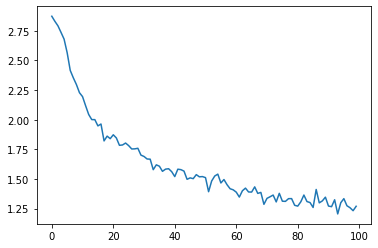

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

- 결과 평가
  - 주축에서 벗어난 밝은 점을 선택하여 잘못 추측한 언어를 표시 할 수 있음
  - 예를 들어 한국어는 중국어로 이탈리아어로 스페인어로. 그리스어는 매우 잘되는 것으로 영어는 매우 나쁜것으로

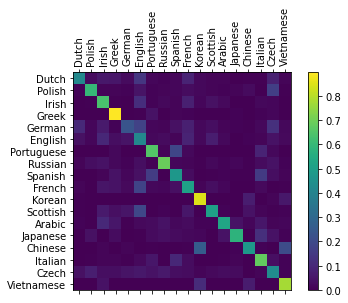

In [ ]:
# 혼란 행렬에서 정확한 추측을 추적
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# 주어진 라인의 출력 반환
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# 예시들 중에 어떤 것이 정확하게 예측되었는지 기록
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# 모든 행을 합계로 나누어 정규화
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# 도식 설정
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# 축 설정
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# 모든 tick에서 레이블 지정
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

- 주축에서 벗어난 밝은 점으로 잘못 추측한 언어 표시
- 예
  - 한국어는 중국어로, 이탈리아어는 스페인어로 잘못 추측함
  - 그리스어는 가로,세로 교차지점이 밝은 노란색 -> 매우 잘 추측하였음
  - 영어는 가로,세로 교차지점이 어두운 색 -> 매우 나쁜 결과

- 사용자 입력을 통해 실행하기

In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.47) Czech
(-1.37) Russian
(-2.57) English

> Jackson
(-0.60) Scottish
(-1.49) English
(-2.56) Russian

> Satoshi
(-1.03) Italian
(-1.53) Japanese
(-2.23) Polish


### 1.3 RNN 기울기 폭발/소실 문제

[1.2342034047289652, 0.8339262435402592, 0.5979099219216478, 0.3924742082554759, 0.25252426453184545, 0.16017442237957719, 0.10106299614538984, 0.06358148956166684, 0.039950839098332, 0.025086887541098325, 0.015748611904532892, 0.009884999125204758, 0.006204151282595104, 0.003893806551809953, 0.002443767399386287, 0.0015337065005571367, 0.0009625497320203268, 0.0006040924319556743, 0.00037912574706291117, 0.00023793756048323344]


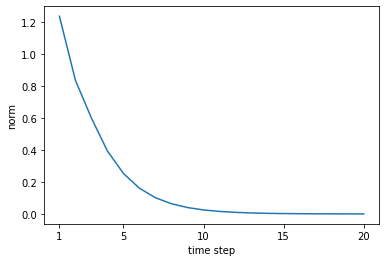

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

N = 2   # 미니배치 크기
H = 3   # 은닉 상태 벡터의 차원 수
T = 20  # 시계열 데이터의 길이

dh = np.ones((N, H))
np.random.seed(3)   # 재현할 수 있도록 난수의 시드 고정

# Wh = np.random.randn(H, H)
Wh = np.random.randn(H, H) * 0.5

norm_list = []
for t in range(T):
  dh = np.matmul(dh, Wh.T)
  norm = np.sqrt(np.sum(dh**2)) / N
  norm_list.append(norm)

print(norm_list)

# 그래프 그리기
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()


- 기울기 클리핑(Gradients Clipping)을 이용한 기울기 폭발(소멸) 대책

In [ ]:
# coding: utf-8
import numpy as np


dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0


def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate


print('before:', dW1.flatten())
clip_grads(grads, max_norm)
print('after:', dW1.flatten())

before: [6.49144048 2.78487283 6.76254902 5.90862817 0.23981882 5.58854088
 2.59252447 4.15101197 2.83525082]
after: [1.49503731 0.64138134 1.55747605 1.36081038 0.05523244 1.28709139
 0.59708178 0.95601551 0.65298384]


## Ⅱ.RNN 활용 예제

### 2.1 영화 리뷰 감정 분석
- RNN 을 이용해 IMDB 데이터를 가지고 텍스트 감정분석을 해 보자.
<br><br>
- 텍스트 형태의 데이터셋인 IMDB 데이터셋은 50,000건의 영화 리뷰로 이루어져 있음.
- 각 리뷰는 다수의 영어 문장들로 이루어져 있으며, 
- 평점이 7점 이상의 긍정적인 영화 리뷰는 2로, 평점이 4점 이하인 부정적인 영화 리뷰는 1로 레이블링 되어 있음.
- 영화 리뷰 텍스트를 RNN 에 입력시켜 영화평의 전체 내용을 압축하고, 이렇게 압축된 리뷰가 긍정적인지 부정적인지 판단해주는 간단한 분류 모델을 만드는 것이 이번 프로젝트의 목표

In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
# from torchtext import datasets        # 현재 버전에서 사라짐 torchtext --> torchtext.legacy 로 변경할 것
from torchtext.legacy import data, datasets

In [4]:
# 하이퍼파라미터
BATCH_SIZE = 64
lr = 0.001
EPOCHS = 10
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("다음 기기로 학습합니다:", DEVICE)

다음 기기로 학습합니다: cuda


In [5]:
TEXT = data.Field(sequential=True, batch_first=True, lower=True)
TEXT

In [6]:
# 데이터 로딩하기
print("데이터 로딩중...")
TEXT = data.Field(sequential=True, batch_first=True, lower=True)
LABEL = data.Field(sequential=False, batch_first=True)
trainset, testset = datasets.IMDB.splits(TEXT, LABEL)
TEXT.build_vocab(trainset, min_freq=5)
LABEL.build_vocab(trainset)



데이터 로딩중...
downloading aclImdb_v1.tar.gz


100%|██████████| 84.1M/84.1M [00:02<00:00, 30.6MB/s]


In [7]:
# 학습용 데이터를 학습셋 80% 검증셋 20% 로 나누기
trainset, valset = trainset.split(split_ratio=0.8)
train_iter, val_iter, test_iter = data.BucketIterator.splits(
        (trainset, valset, testset), batch_size=BATCH_SIZE,
        shuffle=True, repeat=False)


vocab_size = len(TEXT.vocab)
n_classes = 2

In [8]:
print("[학습셋]: %d [검증셋]: %d [테스트셋]: %d [단어수]: %d [클래스] %d"
      % (len(trainset),len(valset), len(testset), vocab_size, n_classes))

[학습셋]: 20000 [검증셋]: 5000 [테스트셋]: 25000 [단어수]: 46159 [클래스] 2


In [9]:
class BasicGRU(nn.Module):
    def __init__(self, n_layers, hidden_dim, n_vocab, embed_dim, n_classes, dropout_p=0.2):
        super(BasicGRU, self).__init__()
        print("Building Basic GRU model...")
        self.n_layers = n_layers
        self.embed = nn.Embedding(n_vocab, embed_dim)
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(embed_dim, self.hidden_dim,
                          num_layers=self.n_layers,
                          batch_first=True)
        self.out = nn.Linear(self.hidden_dim, n_classes)

    def forward(self, x):
        x = self.embed(x)
        h_0 = self._init_state(batch_size=x.size(0))
        x, _ = self.gru(x, h_0)  # [i, b, h]
        h_t = x[:,-1,:]
        self.dropout(h_t)
        logit = self.out(h_t)  # [b, h] -> [b, o]
        return logit
    
    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()


In [10]:
def train(model, optimizer, train_iter):
    model.train()
    for b, batch in enumerate(train_iter):
        x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
        y.data.sub_(1)  # 레이블 값을 0과 1로 변환
        optimizer.zero_grad()

        logit = model(x)
        loss = F.cross_entropy(logit, y)
        loss.backward()
        optimizer.step()

In [11]:
def evaluate(model, val_iter):
    """evaluate model"""
    model.eval()
    corrects, total_loss = 0, 0
    for batch in val_iter:
        x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
        y.data.sub_(1) # 레이블 값을 0과 1로 변환
        logit = model(x)
        loss = F.cross_entropy(logit, y, reduction='sum')
        total_loss += loss.item()
        corrects += (logit.max(1)[1].view(y.size()).data == y.data).sum()
    size = len(val_iter.dataset)
    avg_loss = total_loss / size
    avg_accuracy = 100.0 * corrects / size
    return avg_loss, avg_accuracy

In [12]:
model = BasicGRU(1, 256, vocab_size, 128, n_classes, 0.5).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Building Basic GRU model...


- 아래의 코드는 GPU를 이용해서 실행할 것을 권장함.
- CPU 만으로 실행했을 경우 Epochs=10 의 설정에서 총 3시간 32분 42초 소요됨

In [13]:
best_val_loss = None
for e in range(1, EPOCHS+1):
    train(model, optimizer, train_iter)
    val_loss, val_accuracy = evaluate(model, val_iter)

    print("[이폭: %d] 검증 오차:%5.2f | 검증 정확도:%5.2f" % (e, val_loss, val_accuracy))
    
    # 검증 오차가 가장 적은 최적의 모델을 저장
    if not best_val_loss or val_loss < best_val_loss:
        if not os.path.isdir("snapshot"):
            os.makedirs("snapshot")
        torch.save(model.state_dict(), '{}snapshot/txtclassification.pt'.format(ROOT_PATH))
        best_val_loss = val_loss

KeyboardInterrupt: ignored

- 테스트 수행 시간: 1분 33초(CPU)

In [14]:
model.load_state_dict(torch.load('{}snapshot/txtclassification.pt'.format(ROOT_PATH)))
test_loss, test_acc = evaluate(model, test_iter)
print('테스트 오차: %5.2f | 테스트 정확도: %5.2f' % (test_loss, test_acc))

테스트 오차:  0.35 | 테스트 정확도: 85.13


In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

sentences = ["i like dog", "i love coffee", "i hate milk", "you like cat", "you love milk", "you hate coffee"]
dtype = torch.float

"""
Word Processing
"""
word_list = list(set(" ".join(sentences).split()))
word_dict = {w: i for i, w in enumerate(word_list)}
number_dict = {i: w for i, w in enumerate(word_list)}
n_class = len(word_dict)


"""
TextRNN Parameter
"""
batch_size = len(sentences)
n_step = 2  # 학습 하려고 하는 문장의 길이 - 1
n_hidden = 5  # 은닉층 사이즈

def make_batch(sentences):
  input_batch = []
  target_batch = []

  for sen in sentences:
    word = sen.split()
    input = [word_dict[n] for n in word[:-1]]
    target = word_dict[word[-1]]

    input_batch.append(np.eye(n_class)[input])  # One-Hot Encoding
    target_batch.append(target)
  
  return input_batch, target_batch

input_batch, target_batch = make_batch(sentences)
input_batch = torch.tensor(input_batch, dtype=torch.float32, requires_grad=True)
target_batch = torch.tensor(target_batch, dtype=torch.int64)


"""
TextRNN
"""
class TextRNN(nn.Module):
  def __init__(self):
    super(TextRNN, self).__init__()

    self.rnn = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.3)
    self.W = nn.Parameter(torch.randn([n_hidden, n_class]).type(dtype))
    self.b = nn.Parameter(torch.randn([n_class]).type(dtype))
    self.Softmax = nn.Softmax(dim=1)

  def forward(self, hidden, X):
    X = X.transpose(0, 1)
    outputs, hidden = self.rnn(X, hidden)
    outputs = outputs[-1]  # 최종 예측 Hidden Layer
    model = torch.mm(outputs, self.W) + self.b  # 최종 예측 최종 출력 층
    return model
	

"""
Training
"""
model = TextRNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(500):
  hidden = torch.zeros(1, batch_size, n_hidden, requires_grad=True)
  output = model(hidden, input_batch)
  loss = criterion(output, target_batch)

  if (epoch + 1) % 100 == 0:
    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

input = [sen.split()[:2] for sen in sentences]

hidden = torch.zeros(1, batch_size, n_hidden, requires_grad=True)
predict = model(hidden, input_batch).data.max(1, keepdim=True)[1]
print([sen.split()[:2] for sen in sentences], '->', [number_dict[n.item()] for n in predict.squeeze()])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch: 0100 cost = 0.583964
Epoch: 0200 cost = 0.300110
Epoch: 0300 cost = 0.075719
Epoch: 0400 cost = 0.034730
Epoch: 0500 cost = 0.020617
[['i', 'like'], ['i', 'love'], ['i', 'hate'], ['you', 'like'], ['you', 'love'], ['you', 'hate']] -> ['dog', 'coffee', 'milk', 'cat', 'milk', 'coffee']


### 2.2 문자 RNN으로 성씨 국적 분류하기

#### 2.2.1 데이터 전처리

In [16]:
import collections
import numpy as np
import pandas as pd
import re

from argparse import Namespace

In [17]:
args = Namespace(
    raw_dataset_csv="{}surnames/surnames.csv".format(DATA_PATH),
    train_proportion=0.7,
    val_proportion=0.15,
    test_proportion=0.15,
    output_munged_csv="{}surnames/surnames_with_splits.csv".format(DATA_PATH),
    seed=1337
)

In [18]:
# Read raw data
surnames = pd.read_csv(args.raw_dataset_csv, header=0)

In [19]:
surnames.head()

,surname,nationality
0,Woodford,English
1,Coté,French
2,Kore,English
3,Koury,Arabic
4,Lebzak,Russian


In [20]:
# Unique classes
set(surnames.nationality)

{'Arabic',
 'Chinese',
 'Czech',
 'Dutch',
 'English',
 'French',
 'German',
 'Greek',
 'Irish',
 'Italian',
 'Japanese',
 'Korean',
 'Polish',
 'Portuguese',
 'Russian',
 'Scottish',
 'Spanish',
 'Vietnamese'}

In [21]:
# Splitting train by nationality
# Create dict
by_nationality = collections.defaultdict(list)
for _, row in surnames.iterrows():
    by_nationality[row.nationality].append(row.to_dict())

In [22]:
# Create split data
final_list = []
np.random.seed(args.seed)
for _, item_list in sorted(by_nationality.items()):
    np.random.shuffle(item_list)
    n = len(item_list)
    n_train = int(args.train_proportion*n)
    n_val = int(args.val_proportion*n)
    n_test = int(args.test_proportion*n)
    
    # Give data point a split attribute
    for item in item_list[:n_train]:
        item['split'] = 'train'
    for item in item_list[n_train:n_train+n_val]:
        item['split'] = 'val'
    for item in item_list[n_train+n_val:]:
        item['split'] = 'test'  
    
    # Add to final list
    final_list.extend(item_list)

In [23]:
# Write split data to file
final_surnames = pd.DataFrame(final_list)

In [24]:
final_surnames.split.value_counts()

train    7680
test     1660
val      1640
Name: split, dtype: int64

In [26]:
final_surnames

,surname,nationality,split
0,Totah,Arabic,train
1,Abboud,Arabic,train
2,Fakhoury,Arabic,train
3,Srour,Arabic,train
4,Sayegh,Arabic,train
...,...,...,...
10975,Dinh,Vietnamese,test
10976,Phung,Vietnamese,test
10977,Quang,Vietnamese,test
10978,Vu,Vietnamese,test


In [27]:
# Write munged data to CSV
final_surnames.to_csv(args.output_munged_csv, index=False)

#### 2.2.2 성씨 분류

In [28]:
from argparse import Namespace
import os
import json

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tqdm

- Vocabulary, Vectorizer, Dataset

In [29]:
class Vocabulary(object):
    """매핑을 위해 텍스트를 처리하고 어휘 사전을 만드는 클래스 """

    def __init__(self, token_to_idx=None):
        """
        매개변수:
            token_to_idx (dict): 기존 토큰-인덱스 매핑 딕셔너리
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
    def to_serializable(self):
        """ 직렬화할 수 있는 딕셔너리를 반환합니다 """
        return {'token_to_idx': self._token_to_idx}

    @classmethod
    def from_serializable(cls, contents):
        """ 직렬화된 딕셔너리에서 Vocabulary 객체를 만듭니다 """
        return cls(**contents)

    def add_token(self, token):
        """ 토큰을 기반으로 매핑 딕셔너리를 업데이트합니다

        매개변수:
            token (str): Vocabulary에 추가할 토큰
        반환값:
            index (int): 토큰에 상응하는 정수
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
            
    def add_many(self, tokens):
        """토큰 리스트를 Vocabulary에 추가합니다.
        
        매개변수:
            tokens (list): 문자열 토큰 리스트
        반환값:
            indices (list): 토큰 리스트에 상응되는 인덱스 리스트
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """토큰에 대응하는 인덱스를 추출합니다.
        
        매개변수:
            token (str): 찾을 토큰 
        반환값:
            index (int): 토큰에 해당하는 인덱스
        """
        return self._token_to_idx[token]

    def lookup_index(self, index):
        """ 인덱스에 해당하는 토큰을 반환합니다.
        
        매개변수: 
            index (int): 찾을 인덱스
        반환값:
            token (str): 인텍스에 해당하는 토큰
        에러:
            KeyError: 인덱스가 Vocabulary에 없을 때 발생합니다.
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [30]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)

    def to_serializable(self):
        contents = super(SequenceVocabulary, self).to_serializable()
        contents.update({'unk_token': self._unk_token,
                         'mask_token': self._mask_token,
                         'begin_seq_token': self._begin_seq_token,
                         'end_seq_token': self._end_seq_token})
        return contents

    def lookup_token(self, token):
        """ 토큰에 대응하는 인덱스를 추출합니다.
        토큰이 없으면 UNK 인덱스를 반환합니다.
        
        매개변수:
            token (str): 찾을 토큰 
        반환값:
            index (int): 토큰에 해당하는 인덱스
        노트:
            UNK 토큰을 사용하려면 (Vocabulary에 추가하기 위해)
            `unk_index`가 0보다 커야 합니다.
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

In [31]:
class SurnameVectorizer(object):
    """ 어휘 사전을 생성하고 관리합니다 """
    def __init__(self, char_vocab, nationality_vocab):
        """
        매개변수:
            char_vocab (Vocabulary): 문자를 정수로 매핑합니다
            nationality_vocab (Vocabulary): 국적을 정수로 매핑합니다
        """
        self.char_vocab = char_vocab
        self.nationality_vocab = nationality_vocab

    def vectorize(self, surname, vector_length=-1):
        """
        매개변수:
            title (str): 문자열
            vector_length (int): 인덱스 벡터의 길이를 맞추기 위한 매개변수
        """
        indices = [self.char_vocab.begin_seq_index]
        indices.extend(self.char_vocab.lookup_token(token) 
                       for token in surname)
        indices.append(self.char_vocab.end_seq_index)

        if vector_length < 0:
            vector_length = len(indices)

        out_vector = np.zeros(vector_length, dtype=np.int64)         
        out_vector[:len(indices)] = indices
        out_vector[len(indices):] = self.char_vocab.mask_index
        
        return out_vector, len(indices)

    @classmethod
    def from_dataframe(cls, surname_df):
        """데이터셋 데이터프레임으로 SurnameVectorizer 객체를 초기화합니다.
        
        매개변수:
            surname_df (pandas.DataFrame): 성씨 데이터셋
        반환값:
            SurnameVectorizer 객체
        """
        char_vocab = SequenceVocabulary()
        nationality_vocab = Vocabulary()

        for index, row in surname_df.iterrows():
            for char in row.surname:
                char_vocab.add_token(char)
            nationality_vocab.add_token(row.nationality)

        return cls(char_vocab, nationality_vocab)

    @classmethod
    def from_serializable(cls, contents):
        char_vocab = SequenceVocabulary.from_serializable(contents['char_vocab'])
        nat_vocab =  Vocabulary.from_serializable(contents['nationality_vocab'])

        return cls(char_vocab=char_vocab, nationality_vocab=nat_vocab)

    def to_serializable(self):
        return {'char_vocab': self.char_vocab.to_serializable(), 
                'nationality_vocab': self.nationality_vocab.to_serializable()}

In [32]:
class SurnameDataset(Dataset):
    def __init__(self, surname_df, vectorizer):
        """
        매개변수:
            surname_df (pandas.DataFrame): 데이터셋
            vectorizer (SurnameVectorizer): 데이터셋에서 만든 Vectorizer 객체
        """
        self.surname_df = surname_df 
        self._vectorizer = vectorizer

        self._max_seq_length = max(map(len, self.surname_df.surname)) + 2

        self.train_df = self.surname_df[self.surname_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.surname_df[self.surname_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.surname_df[self.surname_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size), 
                             'val': (self.val_df, self.validation_size), 
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')
        
        # 클래스 가중치
        class_counts = self.train_df.nationality.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.nationality_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)

        
    @classmethod
    def load_dataset_and_make_vectorizer(cls, surname_csv):
        """데이터셋을 로드하고 새로운 Vectorizer 객체를 만듭니다
        
        매개변수:
            surname_csv (str): 데이터셋의 위치
        반환값:
            SurnameDataset의 객체
        """
        surname_df = pd.read_csv(surname_csv)
        train_surname_df = surname_df[surname_df.split=='train']
        return cls(surname_df, SurnameVectorizer.from_dataframe(train_surname_df))
        
    @classmethod
    def load_dataset_and_load_vectorizer(cls, surname_csv, vectorizer_filepath):
        """ 데이터셋과 새로운 Vectorizer 객체를 로드합니다.
        캐시된 Vectorizer 객체를 재사용할 때 사용합니다.
        
        매개변수:
            surname_csv (str): 데이터셋의 위치
            vectorizer_filepath (str): Vectorizer 객체의 저장 위치
        반환값:
            SurnameDataset의 인스턴스
        """
        surname_df = pd.read_csv(surname_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(surname_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """파일에서 Vectorizer 객체를 로드하는 정적 메서드
        
        매개변수:
            vectorizer_filepath (str): 직렬화된 Vectorizer 객체의 위치
        반환값:
            SurnameVectorizer의 인스턴스
        """
        with open(vectorizer_filepath) as fp:
            return SurnameVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """Vectorizer 객체를 json 형태로 디스크에 저장합니다
        
        매개변수:
            vectorizer_filepath (str): Vectorizer 객체의 저장 위치
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ 벡터 변환 객체를 반환합니다 """
        return self._vectorizer

    def set_split(self, split="train"):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """파이토치 데이터셋의 주요 진입 메서드
        
        매개변수:
            index (int): 데이터 포인트 인덱스
        반환값:
            다음 값을 담고 있는 딕셔너리:
                특성 (x_data)
                레이블 (y_target)
                특성 길이 (x_length)
        """
        row = self._target_df.iloc[index]
        
        surname_vector, vec_length = \
            self._vectorizer.vectorize(row.surname, self._max_seq_length)
        
        nationality_index = \
            self._vectorizer.nationality_vocab.lookup_token(row.nationality)

        return {'x_data': surname_vector, 
                'y_target': nationality_index, 
                'x_length': vec_length}

    def get_num_batches(self, batch_size):
        """배치 크기가 주어지면 데이터셋으로 만들 수 있는 배치 개수를 반환합니다
        
        매개변수:
            batch_size (int)
        반환값:
            배치 개수
        """
        return len(self) // batch_size

    

def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"): 
    """
    파이토치 DataLoader를 감싸고 있는 제너레이터 함수.
    걱 텐서를 지정된 장치로 이동합니다.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

- 모델

In [33]:
def column_gather(y_out, x_lengths):
    ''' y_out에 있는 각 데이터 포인트에서 마지막 벡터 추출합니다

    조금 더 구체적으로 말하면 배치 행 인덱스를 순회하면서
    x_lengths에 있는 값에 해당하는 인덱스 위치의 벡터를 반환합니다.

    매개변수:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, sequence, feature)
        x_lengths (torch.LongTensor, torch.cuda.LongTensor)
            shape: (batch,)

    반환값:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, feature)
    '''
    x_lengths = x_lengths.long().detach().cpu().numpy() - 1

    out = []
    for batch_index, column_index in enumerate(x_lengths):
        out.append(y_out[batch_index, column_index])

    return torch.stack(out)


class ElmanRNN(nn.Module):
    """ RNNCell을 사용하여 만든 엘만 RNN """
    def __init__(self, input_size, hidden_size, batch_first=False):
        """
        매개변수:
            input_size (int): 입력 벡터 크기
            hidden_size (int): 은닉 상태 벡터 크기
            batch_first (bool): 0번째 차원이 배치인지 여부
        """
        super(ElmanRNN, self).__init__()
        
        self.rnn_cell = nn.RNNCell(input_size, hidden_size)
        
        self.batch_first = batch_first
        self.hidden_size = hidden_size

    def _initial_hidden(self, batch_size):
        return torch.zeros((batch_size, self.hidden_size))

    def forward(self, x_in, initial_hidden=None):
        """ ElmanRNN의 정방향 계산
        
        매개변수:
            x_in (torch.Tensor): 입력 데이터 텐서 
                If self.batch_first: x_in.shape = (batch_size, seq_size, feat_size)
                Else: x_in.shape = (seq_size, batch_size, feat_size)
            initial_hidden (torch.Tensor): RNN의 초기 은닉 상태
        반환값:
            hiddens (torch.Tensor): 각 타임 스텝에서 RNN 출력
                If self.batch_first: 
                   hiddens.shape = (batch_size, seq_size, hidden_size)
                Else: hiddens.shape = (seq_size, batch_size, hidden_size)
        """
        if self.batch_first:
            batch_size, seq_size, feat_size = x_in.size()
            x_in = x_in.permute(1, 0, 2)
        else:
            seq_size, batch_size, feat_size = x_in.size()
    
        hiddens = []

        if initial_hidden is None:
            initial_hidden = self._initial_hidden(batch_size)
            initial_hidden = initial_hidden.to(x_in.device)

        hidden_t = initial_hidden
                    
        for t in range(seq_size):
            hidden_t = self.rnn_cell(x_in[t], hidden_t)
            hiddens.append(hidden_t)
            
        hiddens = torch.stack(hiddens)

        if self.batch_first:
            hiddens = hiddens.permute(1, 0, 2)

        return hiddens


class SurnameClassifier(nn.Module):
    """ RNN으로 특성을 추출하고 MLP로 분류하는 분류 모델 """
    def __init__(self, embedding_size, num_embeddings, num_classes,
                 rnn_hidden_size, batch_first=True, padding_idx=0):
        """
        매개변수:
            embedding_size (int): 문자 임베딩의 크기
            num_embeddings (int): 임베딩할 문자 개수
            num_classes (int): 예측 벡터의 크기
                노트: 국적 개수
            rnn_hidden_size (int): RNN의 은닉 상태 크기
            batch_first (bool): 입력 텐서의 0번째 차원이 배치인지 시퀀스인지 나타내는 플래그
            padding_idx (int): 텐서 패딩을 위한 인덱스; 
                torch.nn.Embedding을 참고하세요
        """
        super(SurnameClassifier, self).__init__()

        self.emb = nn.Embedding(num_embeddings=num_embeddings,
                                embedding_dim=embedding_size,
                                padding_idx=padding_idx)
        self.rnn = ElmanRNN(input_size=embedding_size,
                             hidden_size=rnn_hidden_size,
                             batch_first=batch_first)
        self.fc1 = nn.Linear(in_features=rnn_hidden_size,
                         out_features=rnn_hidden_size)
        self.fc2 = nn.Linear(in_features=rnn_hidden_size,
                          out_features=num_classes)

    def forward(self, x_in, x_lengths=None, apply_softmax=False):
        """ 분류기의 정방향 계산
        
        매개변수:
            x_in (torch.Tensor): 입력 데이터 텐서 
                x_in.shape는 (batch, input_dim)입니다
            x_lengths (torch.Tensor): 배치에 있는 각 시퀀스의 길이
                시퀀스의 마지막 벡터를 찾는데 사용합니다
            apply_softmax (bool): 소프트맥스 활성화 함수를 위한 플래그
                크로스-엔트로피 손실을 사용하려면 False로 지정합니다
        반환값:
            결과 텐서. tensor.shape는 (batch, output_dim)입니다.
        """
        x_embedded = self.emb(x_in)
        y_out = self.rnn(x_embedded)

        if x_lengths is not None:
            y_out = column_gather(y_out, x_lengths)
        else:
            y_out = y_out[:, -1, :]

        y_out = F.relu(self.fc1(F.dropout(y_out, 0.5)))
        y_out = self.fc2(F.dropout(y_out, 0.5))

        if apply_softmax:
            y_out = F.softmax(y_out, dim=1)

        return y_out

In [34]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

- 설정

In [35]:
args = Namespace(
    # 날짜와 경로 정보
    surname_csv="data/surnames/surnames_with_splits.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="model_storage/ch6/surname_classification",
    # 모델 하이퍼파라미터
    char_embedding_size=100,
    rnn_hidden_size=64,
    # 훈련 하이퍼파라미터
    num_epochs=100,
    learning_rate=1e-3,
    batch_size=64,
    seed=1337,
    early_stopping_criteria=5,
    # 실행 옵션
    cuda=True,
    catch_keyboard_interrupt=True,
    reload_from_files=False,
    expand_filepaths_to_save_dir=True,
)

# CUDA 체크
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("CUDA 사용여부: {}".format(args.cuda))


if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
# 재현성을 위해 시드 설정
set_seed_everywhere(args.seed, args.cuda)

# 디렉토리 처리
handle_dirs(args.save_dir)

CUDA 사용여부: True


In [ ]:
# 만약 코랩에서 실행하는 경우 아래 코드를 실행하여 전처리된 데이터를 다운로드하세요.
!mkdir data
!wget https://git.io/JtSPf -O data/download.py
!wget https://git.io/JtSPU -O data/get-all-data.sh
!chmod 755 data/get-all-data.sh
%cd data
!./get-all-data.sh
%cd ..

--2022-01-18 15:01:05--  https://git.io/JtSPf
Resolving git.io (git.io)... 52.204.242.176, 54.162.128.250, 18.205.36.100, ...
Connecting to git.io (git.io)|52.204.242.176|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rickiepark/nlp-with-pytorch/main/chapter_6/classifying-surnames/data/download.py [following]
--2022-01-18 15:01:05--  https://raw.githubusercontent.com/rickiepark/nlp-with-pytorch/main/chapter_6/classifying-surnames/data/download.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1572 (1.5K) [text/plain]
Saving to: ‘data/download.py’

data/download.py    100%[===================>]   1.54K  --.-KB/s    in 0s      

2022-01-18 15:01:05 (20.6 MB/s) - ‘data/download.py’ saved [1572/1

In [ ]:
if args.reload_from_files and os.path.exists(args.vectorizer_file):
    # 체크포인트를 로드합니다.
    dataset = SurnameDataset.load_dataset_and_load_vectorizer(args.surname_csv, 
                                                              args.vectorizer_file)
else:
    # 데이터셋과 Vectorizer를 만듭니다.
    dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
    dataset.save_vectorizer(args.vectorizer_file)

vectorizer = dataset.get_vectorizer()

classifier = SurnameClassifier(embedding_size=args.char_embedding_size, 
                               num_embeddings=len(vectorizer.char_vocab),
                               num_classes=len(vectorizer.nationality_vocab),
                               rnn_hidden_size=args.rnn_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index)

- 모델 훈련

In [ ]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}


def update_train_state(args, model, train_state):
    """훈련 상태를 업데이트합니다.

    콤포넌트:
     - 조기 종료: 과대 적합 방지
     - 모델 체크포인트: 더 나은 모델을 저장합니다

    :param args: 메인 매개변수
    :param model: 훈련할 모델
    :param train_state: 훈련 상태를 담은 딕셔너리
    :returns:
        새로운 훈련 상태
    """

    # 적어도 한 번 모델을 저장합니다
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # 성능이 향상되면 모델을 저장합니다
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]
         
        # 손실이 나빠지면
        if loss_t >= loss_tm1:
            # 조기 종료 단계 업데이트
            train_state['early_stopping_step'] += 1
        # 손실이 감소하면
        else:
            # 최상의 모델 저장
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t

            # 조기 종료 단계 재설정
            train_state['early_stopping_step'] = 0

        # 조기 종료 여부 확인
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state


def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [ ]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
    
loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

train_state = make_train_state(args)

epoch_bar = tqdm.notebook.tqdm(desc='training routine', 
                               total=args.num_epochs,
                               position=0)

dataset.set_split('train')
train_bar = tqdm.notebook.tqdm(desc='split=train',
                               total=dataset.get_num_batches(args.batch_size), 
                               position=1, 
                               leave=True)
dataset.set_split('val')
val_bar = tqdm.notebook.tqdm(desc='split=val',
                             total=dataset.get_num_batches(args.batch_size), 
                             position=1, 
                             leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # 훈련 세트에 대한 순회

        # 훈련 세트와 배치 제너레이터 준비, 손실과 정확도를 0으로 설정
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # 훈련 과정은 5단계로 이루어집니다

            # --------------------------------------
            # 단계 1. 그레이디언트를 0으로 초기화합니다
            optimizer.zero_grad()

            # 단계 2. 출력을 계산합니다
            y_pred = classifier(x_in=batch_dict['x_data'], 
                                x_lengths=batch_dict['x_length'])

            # 단계 3. 손실을 계산합니다
            loss = loss_func(y_pred, batch_dict['y_target'])
    
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            # 단계 4. 손실을 사용해 그레이디언트를 계산합니다
            loss.backward()

            # 단계 5. 옵티마이저로 가중치를 업데이트합니다
            optimizer.step()
            # -----------------------------------------
            
            # 정확도를 계산합니다
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # 진행 상태 막대 업데이트
            train_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # 검증 세트에 대한 순회

        # 검증 세트와 배치 제너레이터 준비, 손실과 정확도를 0으로 설정
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # 단계 1. 출력을 계산합니다
            y_pred = classifier(x_in=batch_dict['x_data'], 
                                x_lengths=batch_dict['x_length'])

            # 단계 2. 손실을 계산합니다
            loss = loss_func(y_pred, batch_dict['y_target'])
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            # 단계 3. 정확도를 계산합니다
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier, 
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()

        if train_state['stop_early']:
            break
            
except KeyboardInterrupt:
    print("반복 중지")

training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/120 [00:00<?, ?it/s]

split=val:   0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
# 가장 좋은 모델을 사용해 테스트 세트의 손실과 정확도를 계산합니다
classifier.load_state_dict(torch.load(train_state['model_filename']))

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # 출력을 계산합니다
    y_pred =  classifier(batch_dict['x_data'],
                         x_lengths=batch_dict['x_length'])
    
    # 손실을 계산합니다
    loss = loss_func(y_pred, batch_dict['y_target'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # 정확도를 계산합니다
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

In [ ]:
print("테스트 손실: {};".format(train_state['test_loss']))
print("테스트 정확도: {}".format(train_state['test_acc']))

테스트 손실: 1.755407967567444;
테스트 정확도: 42.62499999999999


- 추론

In [ ]:
def predict_nationality(surname, classifier, vectorizer):
    vectorized_surname, vec_length = vectorizer.vectorize(surname)
    vectorized_surname = torch.tensor(vectorized_surname).unsqueeze(dim=0)
    vec_length = torch.tensor([vec_length], dtype=torch.int64)
    
    result = classifier(vectorized_surname, vec_length, apply_softmax=True)
    probability_values, indices = result.max(dim=1)
    
    index = indices.item()
    prob_value = probability_values.item()

    predicted_nationality = vectorizer.nationality_vocab.lookup_index(index)

    return {'nationality': predicted_nationality, 'probability': prob_value, 'surname': surname}

In [ ]:
# surname = input("Enter a surname: ")
classifier = classifier.to("cpu")
for surname in ['McMahan', 'Nakamoto', 'Wan', 'Cho']:
    print(predict_nationality(surname, classifier, vectorizer))

{'nationality': 'Irish', 'probability': 0.37646836042404175, 'surname': 'McMahan'}
{'nationality': 'Japanese', 'probability': 0.6958811283111572, 'surname': 'Nakamoto'}
{'nationality': 'Korean', 'probability': 0.34958624839782715, 'surname': 'Wan'}
{'nationality': 'Korean', 'probability': 0.35665804147720337, 'surname': 'Cho'}
